# MC1 GBSV
## Import

In [6]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy.signal import correlate
import pandas as pd
import numpy as np
from matplotlib.widgets import Slider


## Anwendungsfall und Problemstellung

**Problemstellung:**  
Der Klimawandel schreitet stetig voran, und die globalen Temperaturen steigen weiter an. In den letzten Jahren sind die Temperaturveränderungen immer deutlicher geworden, und es gibt zunehmende Besorgnis über deren Auswirkungen auf das Klima. Es stellt sich die Frage, ob die langfristige Erwärmung der Erde mit spezifischen Mustern oder Trends zusammenhängt, die durch den Klimawandel bedingt sind.

**Ziel der Analyse:**  
Ziel der Analyse ist es, die Temperaturdaten der letzten 10 Jahre für Basel zu untersuchen, um wiederkehrende Muster und mögliche langfristige Veränderungen durch den Klimawandel zu identifizieren. Dabei wird die Auto-Korrelation verwendet, um saisonale Schwankungen und periodische Muster zu erkennen. Insbesondere soll geprüft werden, wie sich die Temperaturen im Vergleich zu früheren Jahren entwickeln und ob die Abnahme der Autokorrelation auf langfristige Veränderungen im Klimatrend hinweist. Es wird analysiert, ob die Korrelation zwischen den Temperaturen im Laufe der Jahre abnimmt, was auf eine zunehmende Veränderung oder Verstärkung der saisonalen und langfristigen Muster durch den Klimawandel hindeuten könnte. Ziel ist es, zu verstehen, inwieweit sich die jährlichen Temperaturverläufe verändern und welche Schlussfolgerungen über zukünftige klimatische Entwicklungen gezogen werden können.

**Auswahl des 1D-Signals**  
Das Signal, das ich untersuche, sind tägliche Durchschnittstemperaturen aus Basel über einen Zeitraum von 10 Jahren. Dieses Signal ist eindimensional (1D), da es sich um eine Zeitreihe handelt, in der Temperaturwerte über die Zeit gemessen wurden.
Ich erwarte, dass sich saisonale Muster mit einer Periodizität von ungefähr 365 Tagen zeigen, da sich die Jahreszeiten wiederholen. Zudem könnten langfristige Trends wie Klimaerwärmung oder ungewöhnliche Wettereinflüsse sichtbar werden.

## Code zum Abrufen der Temperaturdaten von den letzten 10 Jahren in Basel (Muss nur einmal ausgeführt werden, um die Daten in ein CVS zu speichern)


In [18]:
# Dieser Code kann so von der API kopiert werden
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 47.5584,
    "longitude": 7.5733,
    "start_date": "2015-01-01",
    "end_date": "2024-12-31",
    "daily": "temperature_2m_mean"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()

# Konvertiere die Zeit in das Datum ohne Uhrzeit und Zeitzone
start_date = pd.to_datetime(daily.Time(), unit="s", utc=True).normalize()  # Normalize removes the time component
end_date = pd.to_datetime(daily.TimeEnd(), unit="s", utc=True).normalize()  # Normalize removes the time component

# Erstelle die Zeitreihe mit dem gewünschten Format
daily_data = {"date": pd.date_range(
    start=start_date,  # Das erste Datum verwenden
    end=end_date,  # Das Enddatum verwenden
    freq=pd.Timedelta(seconds=daily.Interval()),
    inclusive="left"
)}

daily_data["temperature_2m_mean"] = daily_temperature_2m_mean

daily_dataframe = pd.DataFrame(data=daily_data)

# Speichern der CSV-Datei
output_dir = "Data"
os.makedirs(output_dir, exist_ok=True)  # Erstelle den Ordner, falls er nicht existiert
csv_path = os.path.join(output_dir, "weather_data.csv")

daily_dataframe.to_csv(csv_path, index=False)


Coordinates 47.5571174621582°N 7.549342155456543°E
Elevation 283.0 m asl
Timezone NoneNone
Timezone difference to GMT+0 0 s


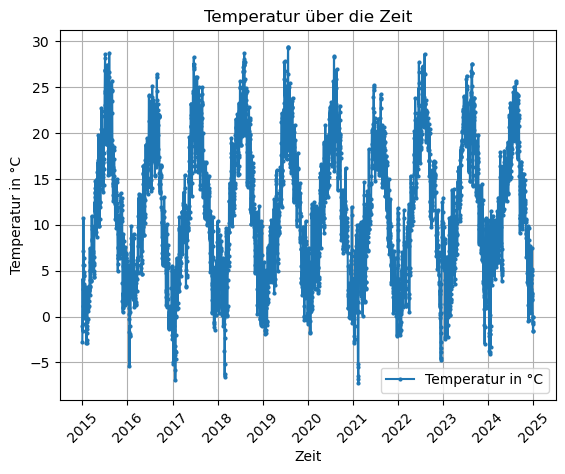

In [8]:
# CSV-Datei laden
csv_path = "C:\\Users\silas\PycharmProjects\GBSV_2025\MC1\Data\weather_data.csv"
if not os.path.exists(csv_path):
    print(f"Fehler: Datei {csv_path} nicht gefunden!")
else:
    daily_dataframe = pd.read_csv(csv_path, parse_dates=["date"])

    # Plot erstellen
    plt.plot(daily_dataframe["date"], daily_dataframe["temperature_2m_mean"], linestyle="-", marker="o", markersize=2, label="Temperatur in °C")

    # Achsentitel und Beschriftungen
    plt.xlabel("Zeit")
    plt.ylabel("Temperatur in °C")
    plt.title("Temperatur über die Zeit")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    # Plot anzeigen
    plt.show()

# Autokorrelation- Analysieren der Resultate
Bei der Autokorrelation ist deutlich erkennbar, dass die Temperaturdaten eine periodische Wiederholung aufweisen, was den erwarteten saisonalen Schwankungen entspricht. Durch die monatlichen Balkendiagramme wird sichtbar, dass sich die Temperaturen über die letzten 10 Jahre hinweg nur geringfügig verändert haben, jedoch kein klarer Trend ersichtlich ist. Dies spiegelt sich auch im abschliessenden Plot wider, in dem ich die durchschnittlichen Temperaturen über die Jahre vergleiche.

Die Wahl einer hohen Lag-Zahl ist sinnvoll, da sie eine langfristige Analyse ermöglicht und dabei hilft, wiederkehrende Muster wie die Jahreszeitenzyklen sichtbar zu machen. Aus diesem Grund würde ich eine höhere Lag-Zahl empfehlen.

Die allmähliche Abnahme der Autokorrelation zeigt, dass der Einfluss vergangener Temperaturen mit der Zeit schwächer wird, jedoch bleiben regelmässige Schwankungen erhalten.

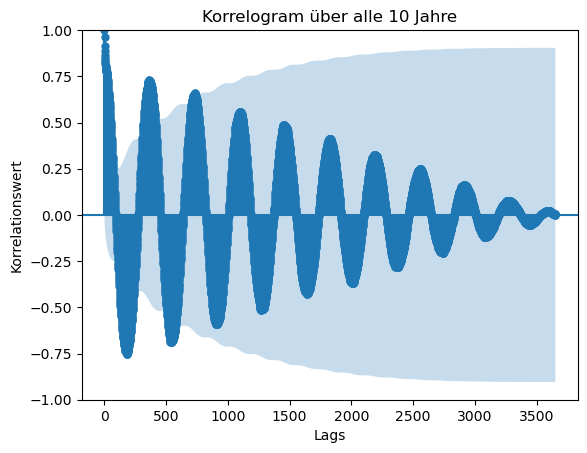

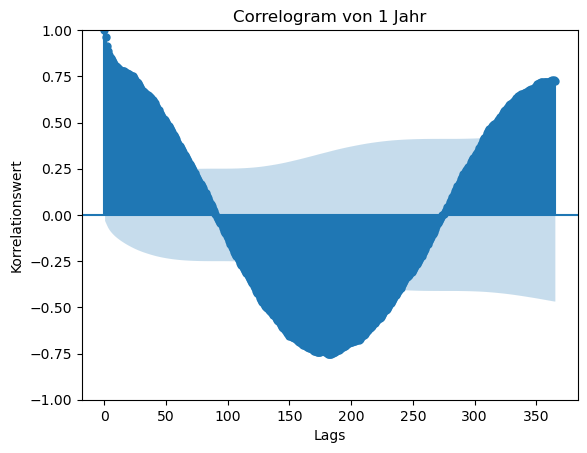

In [9]:
# Überprüfe, ob die Daten korrekt sind und NaN-Werte entfernen
temperature_data = daily_dataframe["temperature_2m_mean"].dropna()

# Bestimme die Anzahl der Lags (Verzögerungen)
lags = len(temperature_data) - 1
lags_1 = 365

# Konvertiere die Daten, falls nötig
temperature_data = temperature_data.to_numpy()

# Plot der Auto-Korrelation
sm.graphics.tsa.plot_acf(temperature_data, lags=lags, title="Korrelogram über alle 10 Jahre")
plt.xlabel("Lags")
plt.ylabel("Korrelationswert")
sm.graphics.tsa.plot_acf(temperature_data, lags=lags_1, title="Correlogram von 1 Jahr")

# Achsentitel und Plot anzeigen
plt.xlabel("Lags")
plt.ylabel("Korrelationswert")
plt.show()

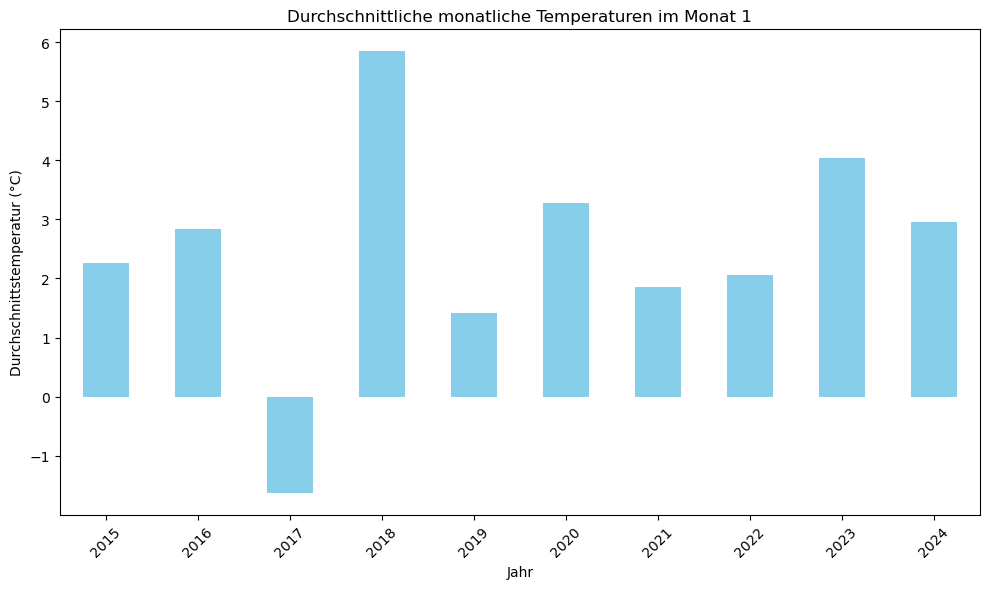

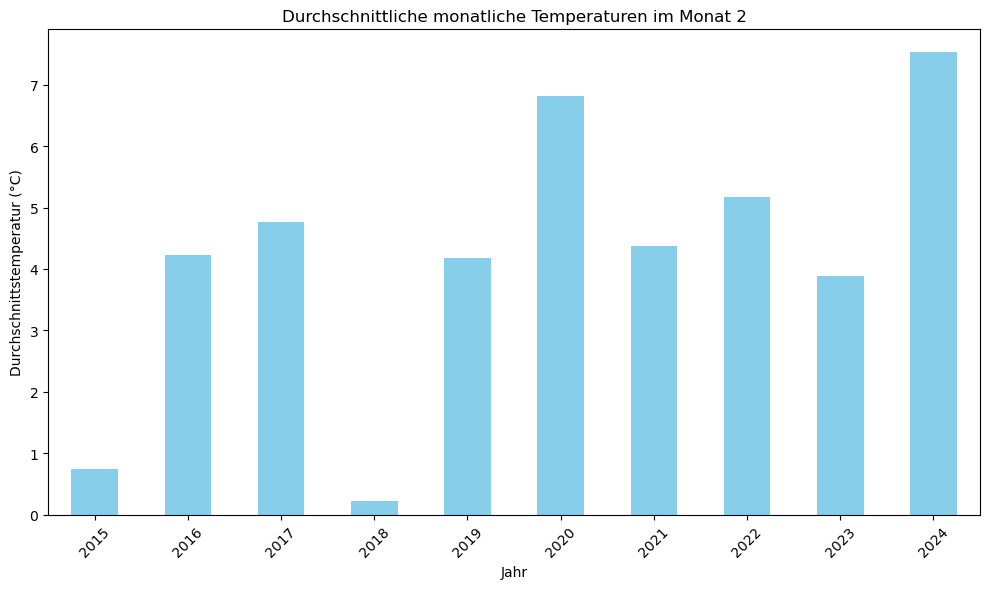

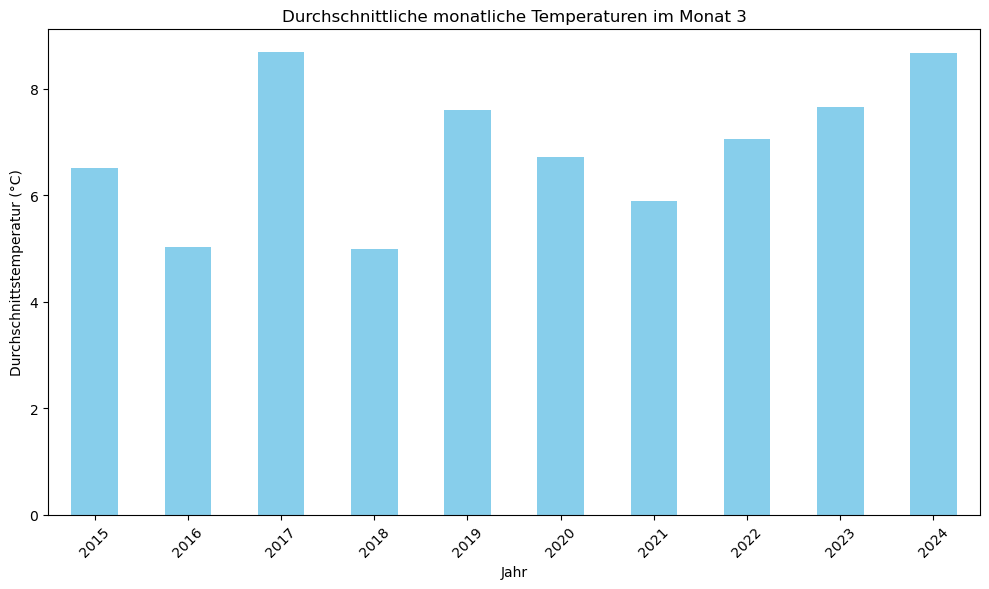

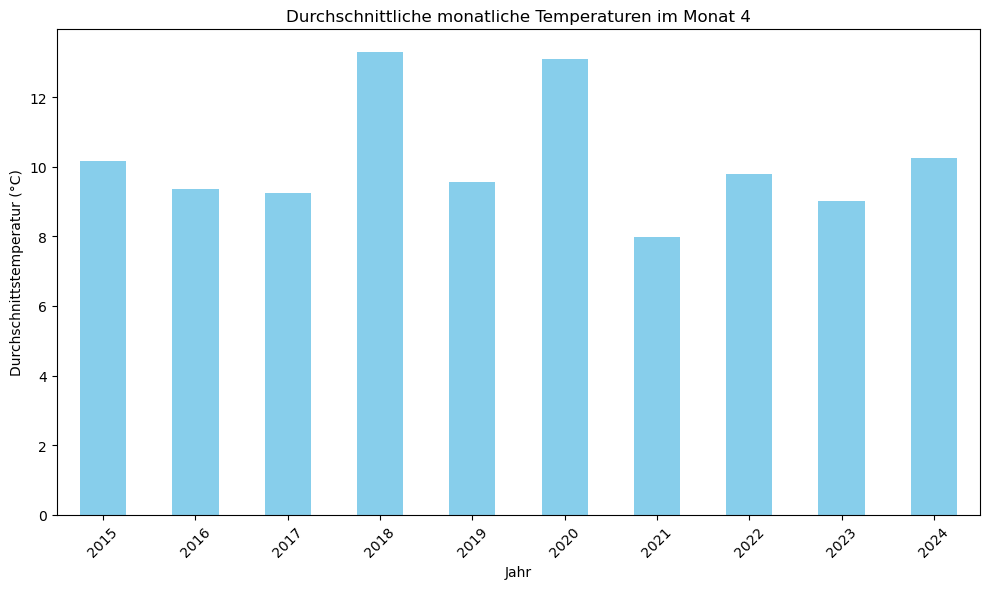

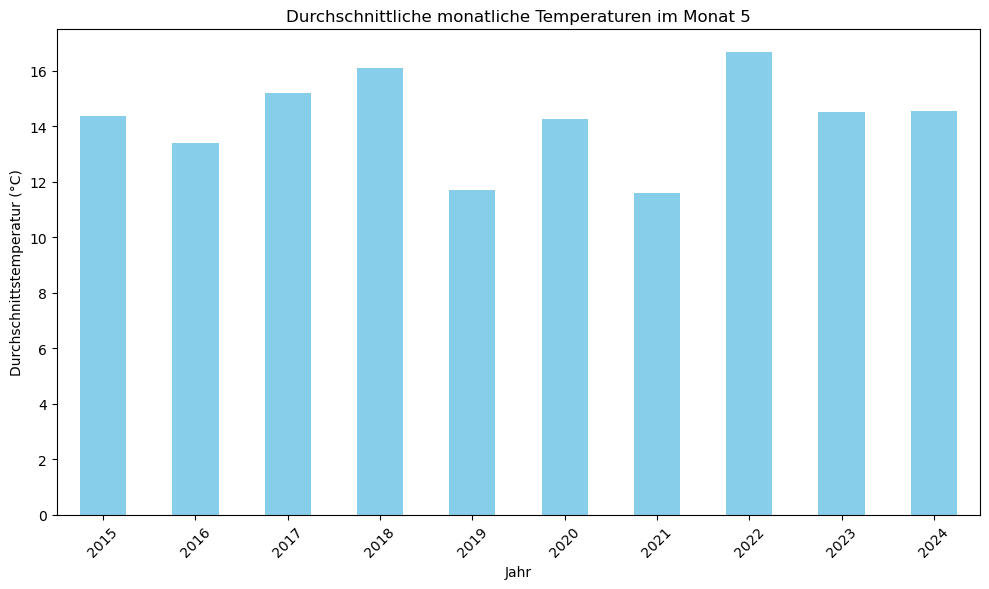

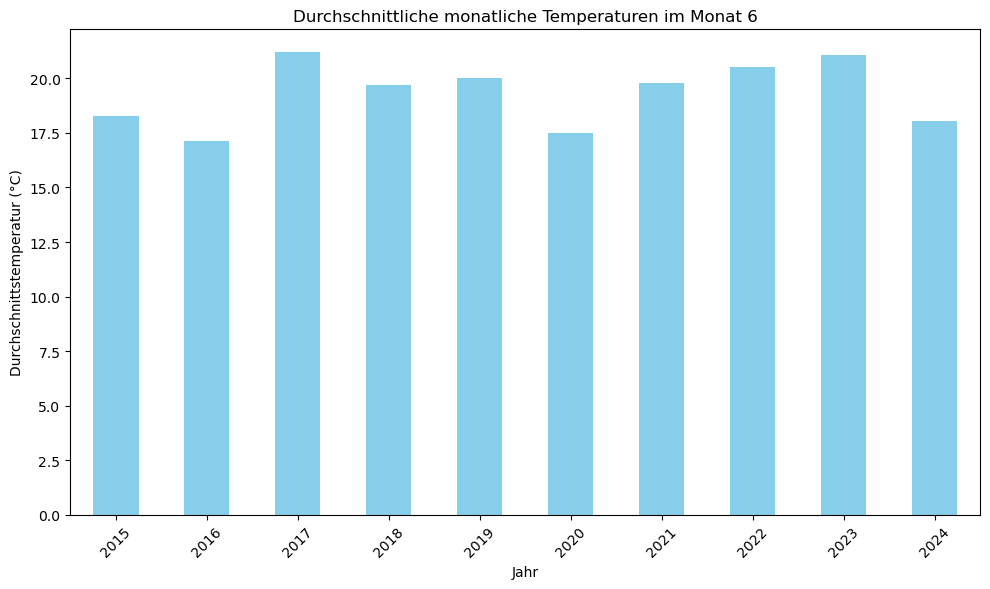

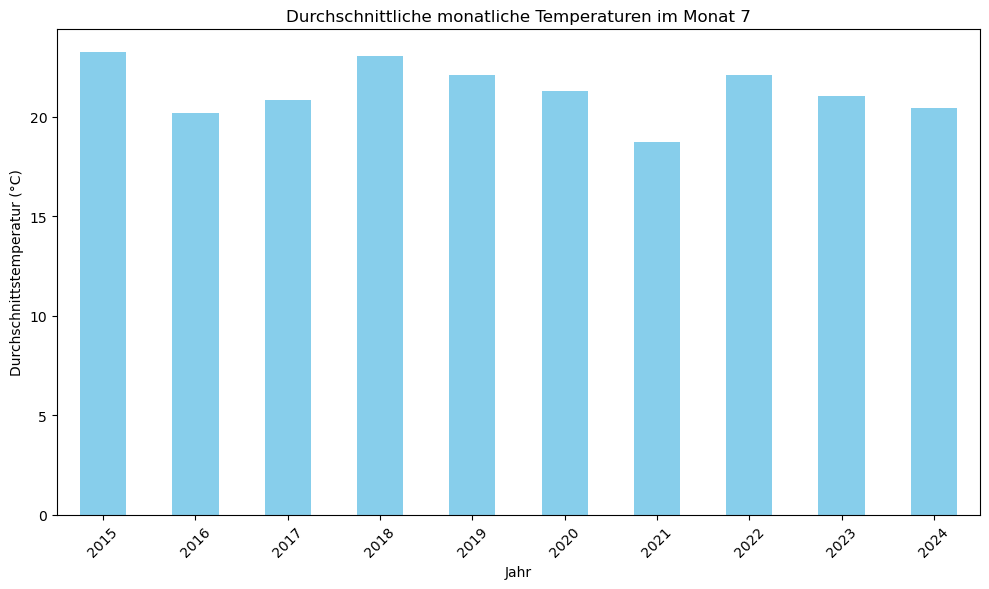

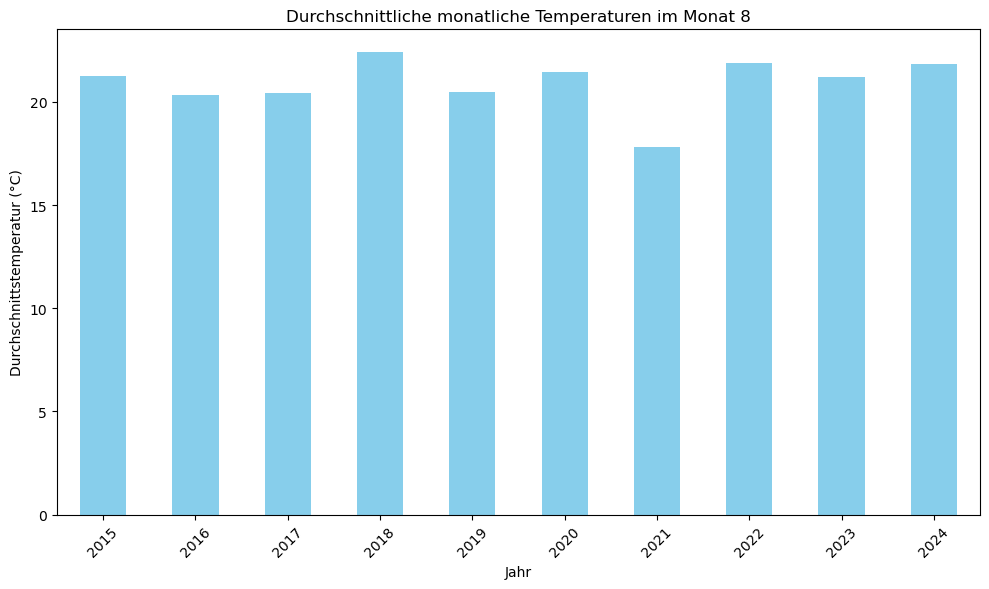

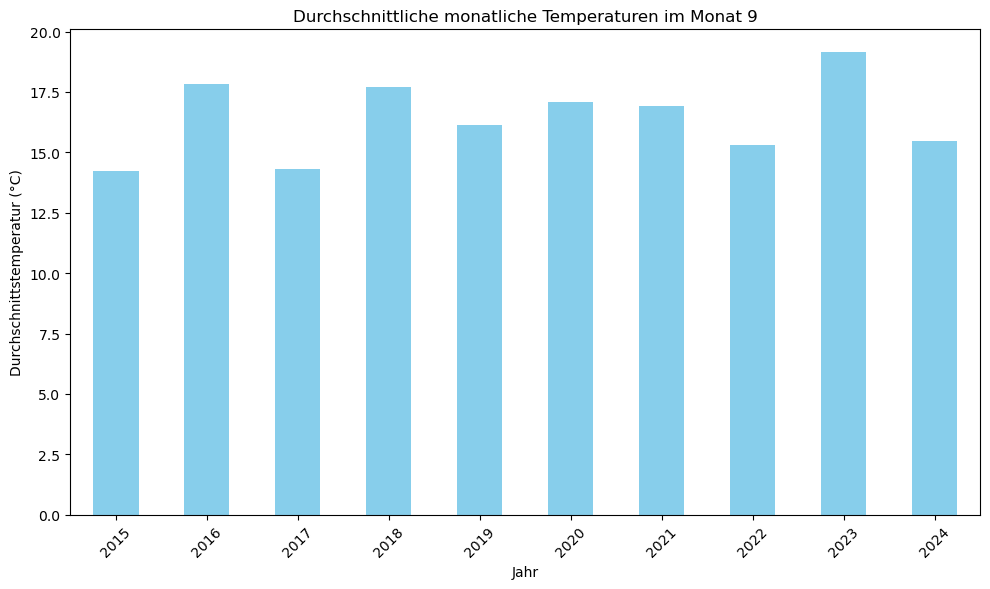

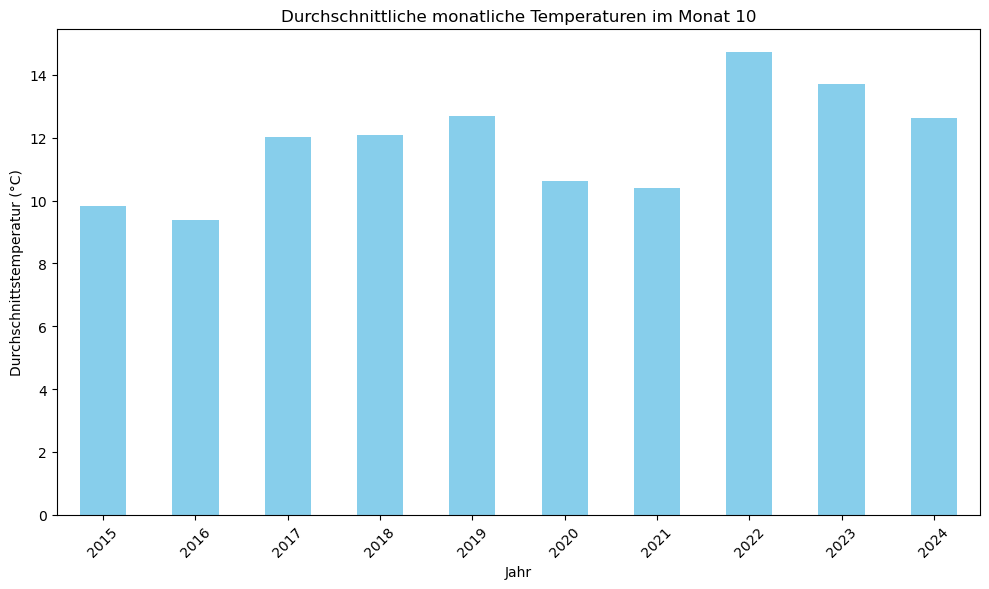

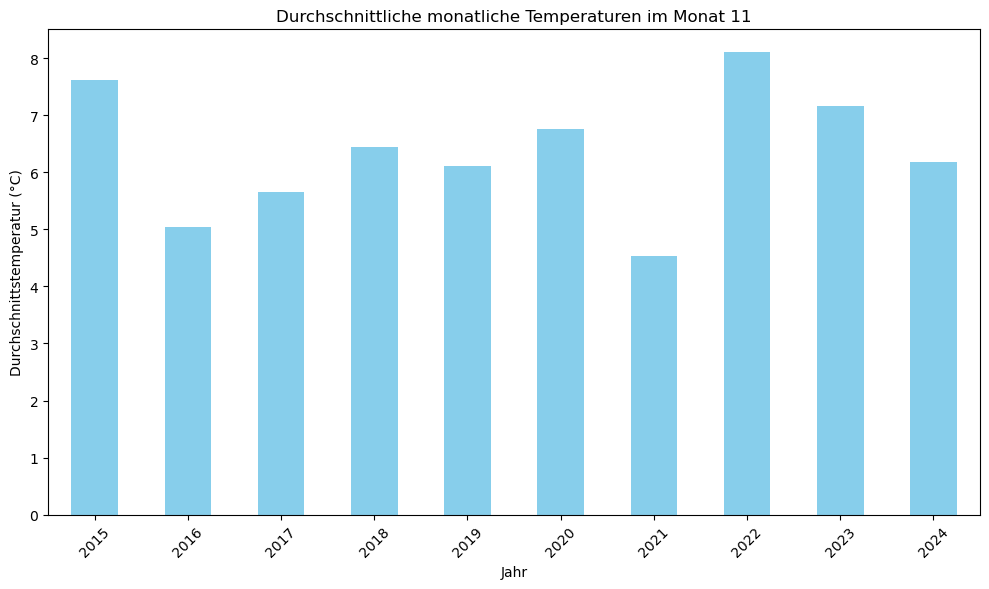

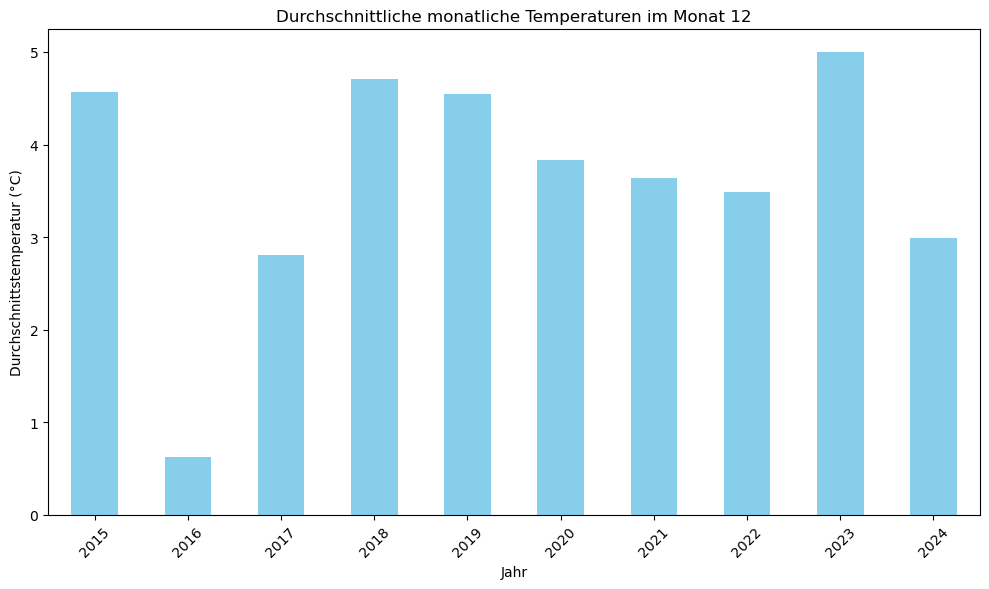

In [10]:
#Monatliche Durchschnittsanalyse
daily_dataframe['date'] = pd.to_datetime(daily_dataframe['date'])  # Falls die 'date' noch nicht als Datetime vorliegt
daily_dataframe = daily_dataframe.dropna(subset=['temperature_2m_mean'])

# Extrahiere den Monat und das Jahr aus der 'date' Spalte
daily_dataframe['month'] = daily_dataframe['date'].dt.month
daily_dataframe['year'] = daily_dataframe['date'].dt.year

# Erstelle für jeden Monat einen Balkenplot
for month in range(1, 13):  # Von Januar (1) bis Dezember (12)
    # Filtere die Daten für den jeweiligen Monat
    monthly_data = daily_dataframe[daily_dataframe['month'] == month]
    
    # Berechne die durchschnittliche Temperatur pro Jahr für den jeweiligen Monat
    monthly_avg_temp_yearly = monthly_data.groupby('year')['temperature_2m_mean'].mean()

    # Erstelle den Balkenplot für den jeweiligen Monat
    plt.figure(figsize=(10, 6))
    monthly_avg_temp_yearly.plot(kind='bar', color='skyblue')
    
    # Diagrammtitel und Achsentitel
    plt.title(f'Durchschnittliche monatliche Temperaturen im Monat {month}')
    plt.xlabel('Jahr')
    plt.ylabel('Durchschnittstemperatur (°C)')
    
    # Achsentitel und Plot anpassen
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

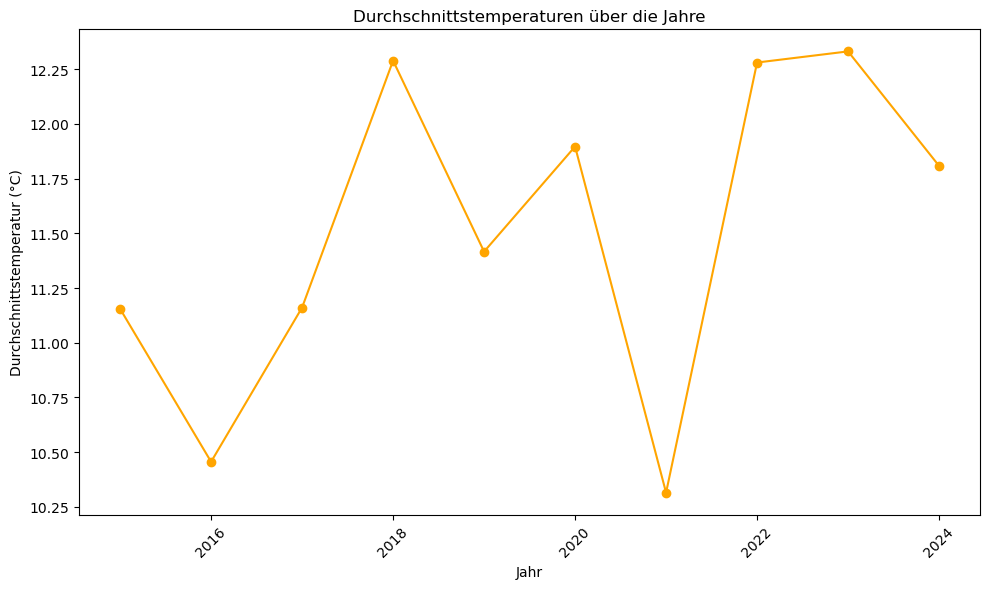

In [11]:
# Berechne den jährlichen Durchschnitt der Temperaturen über alle Monate
yearly_avg_temp = daily_dataframe[daily_dataframe['year'] <= 2024].groupby('year')['temperature_2m_mean'].mean()


# Erstelle ein Plot der durchschnittlichen Temperaturen über die Jahre
plt.figure(figsize=(10, 6))
yearly_avg_temp.plot(kind='line', marker='o', color='orange')

# Diagrammtitel und Achsentitel
plt.title('Durchschnittstemperaturen über die Jahre')
plt.xlabel('Jahr')
plt.ylabel('Durchschnittstemperatur (°C)')

# Achsen anpassen und Plot anzeigen
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Kreuzkorrelation - Definition eines Anwendungsfalls für Signal Erkennung
**Problemstellung & Anwendungsfall**

Ein interessantes Anwendungsszenario für die Analyse der Temperaturdaten von Basel ist die Untersuchung der Auswirkungen des Covid-19-Lockdowns auf die lokalen Temperaturen. Der Lockdown führte zu einer erheblichen Reduktion menschlicher Aktivitäten, was möglicherweise messbare Veränderungen in den Temperaturen zur Folge hatte. Das Erkennen solcher Veränderungen kann für verschiedene Anwendungen nützlich sein, z. B. in der Klimaforschung, der Umweltplanung oder der städtischen Entwicklung.

**Auswahl des Teil-Signals & Ziel**

Ich werde die Temperaturdaten vom 16. März 2020 bis zum 30. April 2020 als Teilsignal ausschneiden.

- **Warum diese Wahl?** Dieser Zeitraum umfasst die Wochen des Covid-19-Lockdowns, in dem menschliche Aktivitäten wie Verkehr und Industrieproduktion stark reduziert wurden. Dies bietet eine einzigartige Gelegenheit, die Auswirkungen dieser Reduktion auf die lokalen Temperaturen zu untersuchen.
- **Ziel der Analyse:** Ich möchte prüfen, ob die reduzierte menschliche Aktivität während des Lockdowns zu messbaren Veränderungen in den Temperaturen geführt hat.
- **Erwartung:** Es wird erwartet, dass die Temperaturen während des Lockdowns möglicherweise geringfügige Veränderungen aufweisen, die auf die reduzierte Luftverschmutzung und geringere Wärmeabgabe durch menschliche Aktivitäten zurückzuführen sein könnten. Somit erwarte ich keine grosse Korrelation aus dem gesamtdatensatz im vergleich zu meinem ROI.
- **Relevanz:** Die Erkennung und Analyse dieser Veränderungen kann helfen, die Auswirkungen menschlicher Aktivitäten auf das lokale Klima besser zu verstehen und zukünftige Massnahmen zur Reduzierung der städtischen Erwärmung und zur Verbesserung der Luftqualität zu entwickeln.

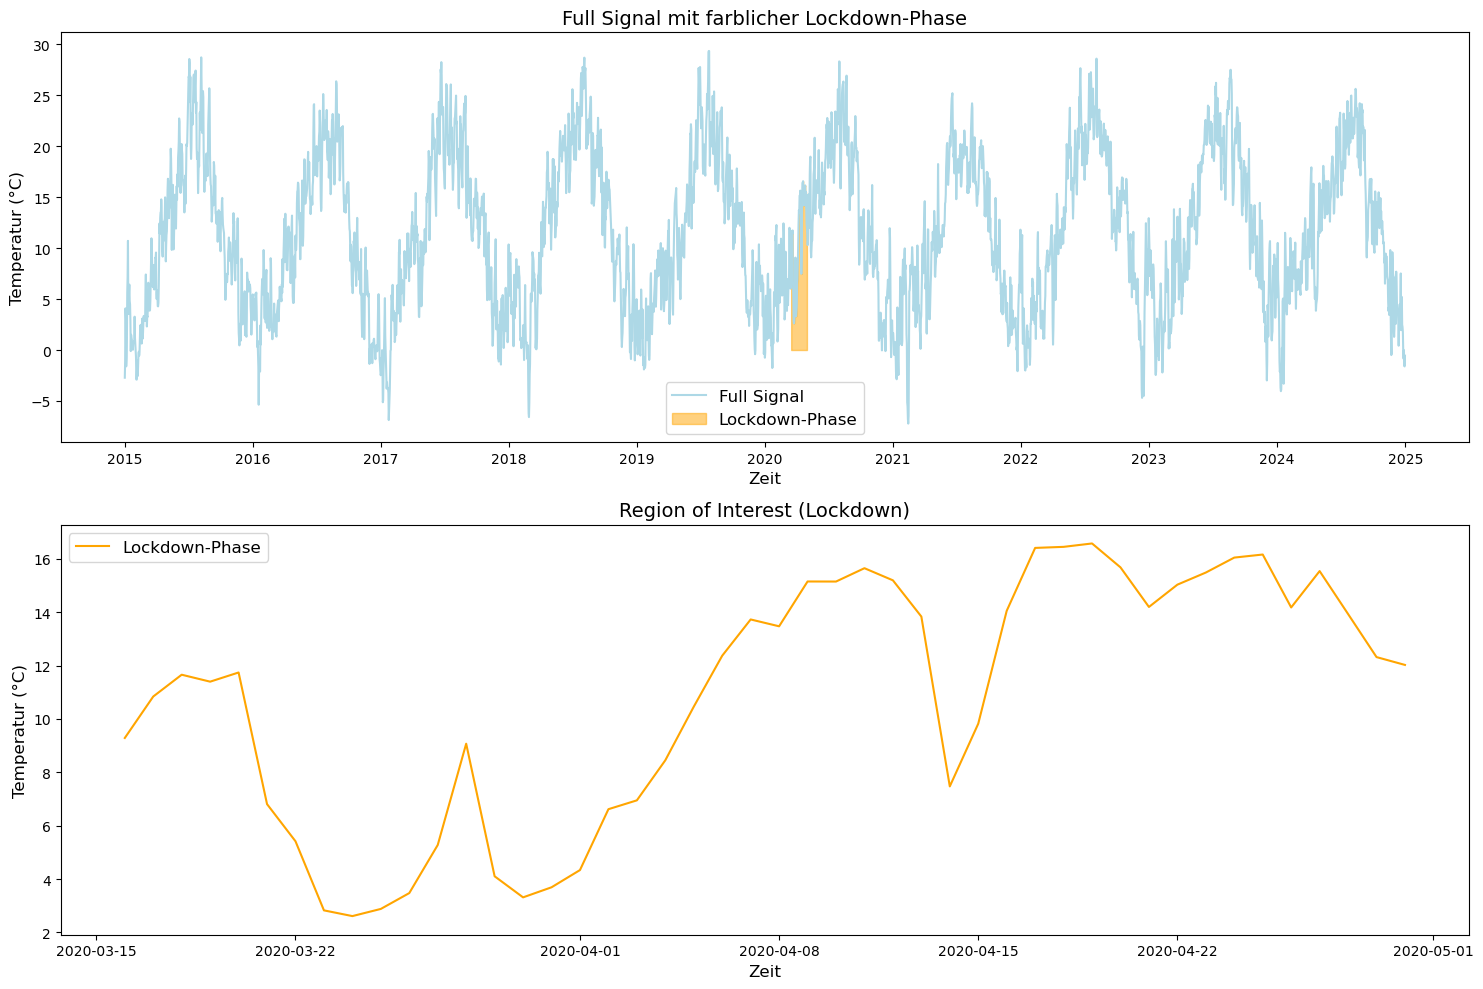

In [12]:
# CSV-Datei laden
df = pd.read_csv(csv_path, parse_dates=["date"])
df.set_index("date", inplace=True)
df = df.dropna(subset=["temperature_2m_mean"])  # Fehlwerte entfernen

# Zeitraum der Lockdown-Phase definieren
lockdown_start = "2020-03-16"
lockdown_end = "2020-04-30"

# Sicherstellen, dass das Zeitfenster existiert
roi = df.loc[lockdown_start:lockdown_end, "temperature_2m_mean"]
full_signal = df["temperature_2m_mean"]

# Kreuzkorrelation berechnen
correlation = correlate(full_signal - np.mean(full_signal), roi - np.mean(roi), mode="full")

# Erstelle die Subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Originaldaten
axs[0].plot(full_signal.index, full_signal, color="lightblue", label="Full Signal")
axs[0].fill_between(roi.index, roi, color="orange", alpha=0.5, label="Lockdown-Phase")  # ROI einfärben
axs[0].set_title("Full Signal mit farblicher Lockdown-Phase", fontsize=14)
axs[0].set_xlabel("Zeit", fontsize=12)
axs[0].set_ylabel("Temperatur (°C)", fontsize=12)
axs[0].legend(fontsize=12)

# ROI (Heatwave)
axs[1].plot(roi.index, roi, color="orange", label="Lockdown-Phase")
axs[1].set_title("Region of Interest (Lockdown)", fontsize=14)
axs[1].set_xlabel("Zeit", fontsize=12)
axs[1].set_ylabel("Temperatur (°C)", fontsize=12)
axs[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

## Interpretation
Auf dem Graphen ist zu sehen, dass mein Modell, den ROI wieder finden kann. Zudem ist ebenfalls ersichtlich, dass wir weitere hohe korrelationen in den Daten finden, welche mit einem Schwellwert von 0.9 initial eingezeichnet wurden. Aber trotzdem, ist es auch ersichtlich, dass es rund 10 hohe Peaks gibt, was darauf hinweist, dass sich die Temperatur über den Lockdown nicht gross verändert hat.

In [8]:
# Kreuzkorrelationsberechnung
def calculate_cross_correlation(s1, s2, do_normalize=True):
    s1 = np.array(s1).flatten()
    s2 = np.array(s2).flatten()

    if do_normalize:
        s1 = s1 - np.mean(s1)
        s2 = s2 - np.mean(s2)

    corr = np.correlate(s1, s2, mode='full')

    if do_normalize:
        corr /= len(s1)

    return corr

# Kreuzkorrelation berechnen
cross_corr = calculate_cross_correlation(full_signal, roi)

# Lags erstellen (Zeitenversatz)
lags = np.arange(-len(roi) + 1, len(full_signal))

# Finden des höchsten Korrelationswerts
max_index = np.argmax(cross_corr)
max_lag = lags[max_index]
lag_date = full_signal.index[max_index]
lag_date_formatted = lag_date.strftime('%d-%m-%Y')

# Initialer Schwellenwert (90 % des Maximums)
initial_threshold = 0.9

# Setze Backend auf TkAgg für interaktive Plots in PyCharm
import matplotlib
matplotlib.use("TkAgg")

# Interaktiver Plot erstellen
fig, ax = plt.subplots(figsize=(12, 5))
plt.subplots_adjust(bottom=0.25)  # Platz für den Slider

# Hauptplot
ax.plot(lags, cross_corr, linestyle='-', label="Kreuzkorrelation")

# Markiere den höchsten Korrelationswert (rot)
max_point, = ax.plot(max_lag, cross_corr[max_index], 'ro', label=f"Max Korrelation am {lag_date_formatted}")

# Dynamische Markierung der weiteren Peaks (orange)
threshold = initial_threshold * cross_corr[max_index]
high_peaks = np.where(cross_corr >= threshold)[0]
high_lags = lags[high_peaks]
scatter = ax.scatter(high_lags, cross_corr[high_peaks], color='orange', label="Weitere hohe Peaks")

# Zusätzliche Linien zur Orientierung
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.axvline(0, color='black', linestyle='--', linewidth=0.8)

# Achsen und Titel
ax.set_xlabel("Lag [Tage]")
ax.set_ylabel("Normierte Kreuzkorrelation")
ax.set_title("Normierte Kreuzkorrelation mit interaktivem Schwellenwert")
ax.grid(True)

# Legende aueeerhalb des Plots
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Schieberegler für den Schwellenwert
ax_slider = plt.axes([0.2, 0.05, 0.65, 0.03])  # Position des Sliders
slider = Slider(ax_slider, 'Schwellenwert', 0.5, 1.0, valinit=initial_threshold, valstep=0.01)

# Update-Funktion für den Slider
def update(val):
    threshold = slider.val * cross_corr[max_index]
    high_peaks = np.where(cross_corr >= threshold)[0]
    high_lags = lags[high_peaks]
    
    # Scatter-Punkte aktualisieren
    scatter.set_offsets(np.c_[high_lags, cross_corr[high_peaks]])
    fig.canvas.draw_idle()  # Zeichne die Änderungen im Plot neu

# Slider mit Update-Funktion verbinden
slider.on_changed(update)

# Blockierendes Anzeigen des Plots
plt.show(block=True)  # Blockiert, damit der Plot angezeigt bleibt

## 1. Änderung mittels zufälligem Rauschen hinzufügen
**Warum:** Das Hinzufügen von Rauschen kann die Präzision der Kreuzkorrelation verringern, da die Übereinstimmung zwischen den Signalen durch das zufällige Rauschen verzerrt wird. Das Testen mit Rauschen zeigt, wie robust die Methode gegen störende Einflüsse ist.


## 2. Änderung mittels Skalierung
**Warum:** Eine Veränderung der Amplitude des Signals (durch Skalierung) kann ebenfalls getestet werden, um zu sehen, ob die Kreuzkorrelation empfindlich auf solche Transformationen reagiert. Dies hilft zu überprüfen, wie gut das Verfahren bei unterschiedlichen Skalen des Signals funktioniert.

In [ ]:
# Kreuzkorrelationsberechnung
def calculate_cross_correlation(s1, s2, do_normalize=True):
    s1 = np.array(s1).flatten()
    s2 = np.array(s2).flatten()

    if do_normalize:
        s1 = s1 - np.mean(s1)
        s2 = s2 - np.mean(s2)

    corr = np.correlate(s1, s2, mode='full')

    if do_normalize:
        corr /= len(s1)

    return corr

# Funktion zum Hinzufügen von Rauschen
def add_noise(roi, noise_factor):
    noise = np.random.normal(0, noise_factor, len(roi))  # Erzeuge Rauschen
    noisy_roi = roi + noise
    return noisy_roi

# Lags erstellen (Zeitenversatz)
lags = np.arange(-len(roi) + 1, len(full_signal))

# Kreuzkorrelation berechnen
cross_corr = calculate_cross_correlation(full_signal, roi)

# Finden des höchsten Korrelationswerts
max_index = np.argmax(cross_corr)
max_lag = lags[max_index]
lag_date = full_signal.index[max_index]
lag_date_formatted = lag_date.strftime('%d-%m-%Y')

# Initialer Rauschfaktor
initial_noise_factor = 10

# Setze Backend auf TkAgg für interaktive Plots in PyCharm
import matplotlib
matplotlib.use("TkAgg")

# Interaktiver Plot erstellen
fig, ax = plt.subplots(figsize=(12, 5))
plt.subplots_adjust(bottom=0.25)  # Platz für den Slider

# Hauptplot
ax.plot(lags, cross_corr, linestyle='-', label="Kreuzkorrelation")

# Markiere den höchsten Korrelationswert (rot)
max_point, = ax.plot(max_lag, cross_corr[max_index], 'ro', label=f"Max Korrelation am {lag_date_formatted}")

# Dynamische Markierung der weiteren Peaks (orange)
threshold = 0.9 * cross_corr[max_index]
high_peaks = np.where(cross_corr >= threshold)[0]
high_lags = lags[high_peaks]
scatter = ax.scatter(high_lags, cross_corr[high_peaks], color='orange', label="Weitere hohe Peaks")

# Zusätzliche Linien zur Orientierung
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.axvline(0, color='black', linestyle='--', linewidth=0.8)

# Achsen und Titel
ax.set_xlabel("Lag [Tage]")
ax.set_ylabel("Normierte Kreuzkorrelation")
ax.set_title("Normierte Kreuzkorrelation mit interaktivem Rauschen")
ax.grid(True)

# Legende aueeerhalb des Plots
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Schieberegler für den Rauschfaktor
ax_slider = plt.axes([0.2, 0.05, 0.65, 0.03])  # Position des Sliders
slider = Slider(ax_slider, 'Rauschfaktor', 0, 50, valinit=initial_noise_factor, valstep=1)

# Update-Funktion für den Slider
def update(val):
    # Rauschen hinzufügen basierend auf dem aktuellen Schiebereglerwert
    noisy_roi = add_noise(roi, slider.val)
    
    # Kreuzkorrelation für das verrauschte ROI berechnen
    cross_corr_noisy = calculate_cross_correlation(full_signal, noisy_roi)
    
    # Finden des höchsten Korrelationswerts im verrauschten Signal
    max_index_noisy = np.argmax(cross_corr_noisy)
    max_lag_noisy = lags[max_index_noisy]
    lag_date_noisy = full_signal.index[max_index_noisy]
    lag_date_formatted_noisy = lag_date_noisy.strftime('%d-%m-%Y')
    
    # Dynamische Markierung der weiteren Peaks (orange)
    threshold = 0.9 * cross_corr_noisy[max_index_noisy]
    high_peaks = np.where(cross_corr_noisy >= threshold)[0]
    high_lags = lags[high_peaks]
    
    # Aktualisiere den Plot mit den neuen Daten
    ax.clear()  # Lösche den alten Plot
    ax.plot(lags, cross_corr_noisy, linestyle='-', label="Kreuzkorrelation (verrauscht)")
    ax.plot(max_lag_noisy, cross_corr_noisy[max_index_noisy], 'ro', label=f"Max Korrelation am {lag_date_formatted_noisy}")
    scatter = ax.scatter(high_lags, cross_corr_noisy[high_peaks], color='orange', label="Weitere hohe Peaks")
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_xlabel("Lag [Tage]")
    ax.set_ylabel("Normierte Kreuzkorrelation")
    ax.set_title("Normierte Kreuzkorrelation mit interaktivem Rauschen")
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    fig.canvas.draw_idle()  # Zeichne die Änderungen im Plot neu

# Slider mit Update-Funktion verbinden
slider.on_changed(update)

# Blockierendes Anzeigen des Plots
plt.show(block=True)  # Blockiert, damit der Plot angezeigt bleibt

Traceback (most recent call last):
  File "C:\Users\silas\miniconda3\envs\GBSV\Lib\site-packages\matplotlib\cbook.py", line 361, in process
    func(*args, **kwargs)
  File "C:\Users\silas\miniconda3\envs\GBSV\Lib\site-packages\matplotlib\widgets.py", line 592, in <lambda>
    return self._observers.connect('changed', lambda val: func(val))
                                                          ^^^^^^^^^
  File "C:\Users\silas\AppData\Local\Temp\ipykernel_23936\3321512441.py", line 86, in update
    lag_date_noisy = full_signal.index[max_index_noisy]
                     ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "C:\Users\silas\miniconda3\envs\GBSV\Lib\site-packages\pandas\core\indexes\base.py", line 5389, in __getitem__
    return getitem(key)
           ^^^^^^^^^^^^
  File "C:\Users\silas\miniconda3\envs\GBSV\Lib\site-packages\pandas\core\arrays\datetimelike.py", line 381, in __getitem__
    result = cast("Union[Self, DTScalarOrNaT]", super().__getitem__(key))
                    

## Skalierung

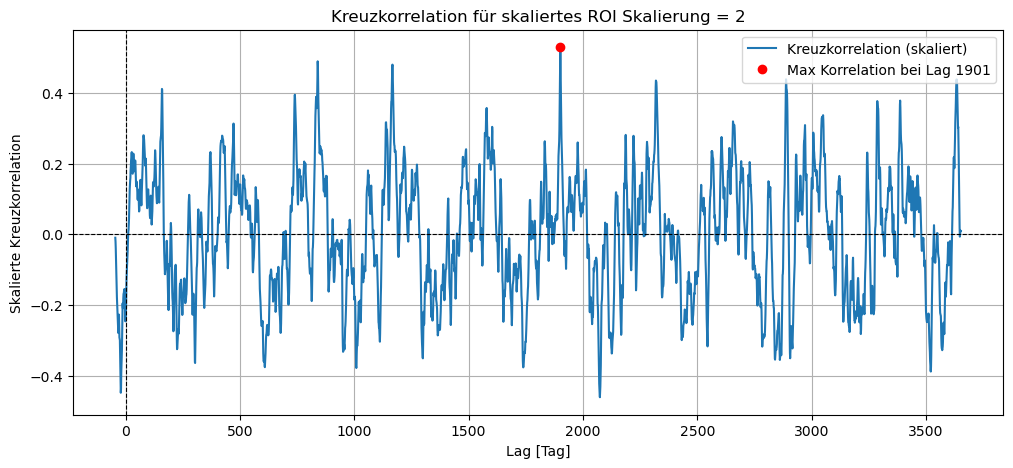

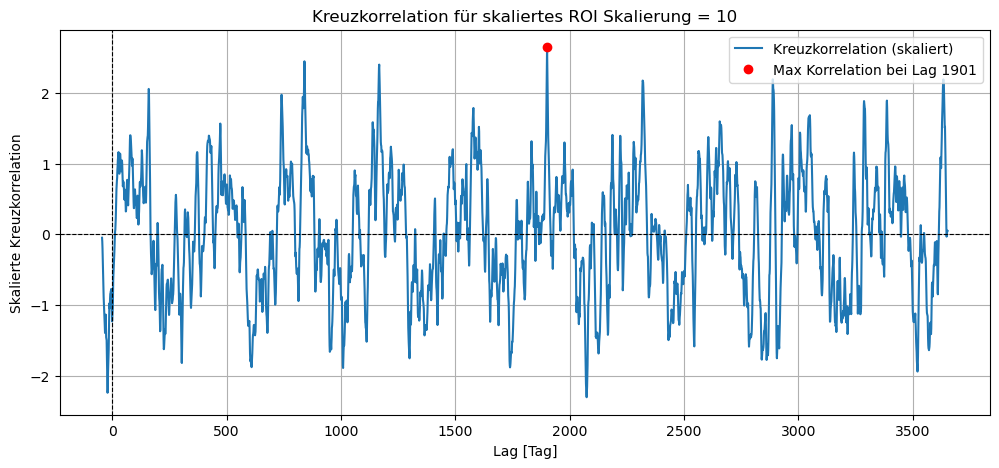

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Kreuzkorrelationsberechnung
def calculate_cross_correlation(s1, s2, do_normalize=True):
    s1 = np.array(s1).flatten()
    s2 = np.array(s2).flatten()

    if do_normalize:
        s1 = s1 - np.mean(s1)
        s2 = s2 - np.mean(s2)

    corr = np.correlate(s1, s2, mode='full')

    if do_normalize:
        corr /= len(s1)

    return corr

# Funktion zum Skalieren des ROI
def scale_roi(roi, scaling_factor):
    return roi * scaling_factor  # Skalieren der Daten mit dem Faktor

# Setze den Skalierungsfaktor
scaling_factor = 2

# Skalieren des ROI
scaled_roi = scale_roi(roi, scaling_factor)

# Berechne die Kreuzkorrelation für das skalierte ROI
cross_corr_scaled = calculate_cross_correlation(full_signal, scaled_roi)

# Lags erstellen (Zeitenversatz)
lags = np.arange(-len(roi) + 1, len(full_signal))

# Finden des höchsten Korrelationswerts und des zugehörigen Lags für das skalierte Signal
max_index_scaled = np.argmax(cross_corr_scaled)
max_lag_scaled = lags[max_index_scaled]

# Plot erstellen für das skalierte Signal und die Kreuzkorrelation
plt.figure(figsize=(12, 5))

# Plot der Kreuzkorrelation des skalierten ROI
plt.plot(lags, cross_corr_scaled, linestyle='-', label="Kreuzkorrelation (skaliert)")

# Markiere den höchsten Korrelationswert mit einem roten Punkt
plt.plot(max_lag_scaled, cross_corr_scaled[max_index_scaled], 'ro', label=f"Max Korrelation bei Lag {max_lag_scaled}")

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

plt.xlabel("Lag [Tag]")
plt.ylabel("Skalierte Kreuzkorrelation")
plt.title("Kreuzkorrelation für skaliertes ROI Skalierung = 2")
plt.grid(True)
plt.legend()

# Sicherstellen, dass der Plot angezeigt wird
plt.show()

# Setze den Skalierungsfaktor
scaling_factor = 10

# Skalieren des ROI
scaled_roi = scale_roi(roi, scaling_factor)

# Berechne die Kreuzkorrelation für das skalierte ROI
cross_corr_scaled = calculate_cross_correlation(full_signal, scaled_roi)

# Lags erstellen (Zeitenversatz)
lags = np.arange(-len(roi) + 1, len(full_signal))

# Finden des höchsten Korrelationswerts und des zugehörigen Lags für das skalierte Signal
max_index_scaled = np.argmax(cross_corr_scaled)
max_lag_scaled = lags[max_index_scaled]

# Plot erstellen für das skalierte Signal und die Kreuzkorrelation
plt.figure(figsize=(12, 5))

# Plot der Kreuzkorrelation des skalierten ROI
plt.plot(lags, cross_corr_scaled, linestyle='-', label="Kreuzkorrelation (skaliert)")

# Markiere den höchsten Korrelationswert mit einem roten Punkt
plt.plot(max_lag_scaled, cross_corr_scaled[max_index_scaled], 'ro', label=f"Max Korrelation bei Lag {max_lag_scaled}")

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

plt.xlabel("Lag [Tag]")
plt.ylabel("Skalierte Kreuzkorrelation")
plt.title("Kreuzkorrelation für skaliertes ROI Skalierung = 10")
plt.grid(True)
plt.legend()

# Sicherstellen, dass der Plot angezeigt wird
plt.show()

## Kreuzkorrelation Diskussion und Interpretierung

### Parameter

**Rauschen mit Regler:** Das Hinzufügen von Rauschen mit einem Regler ermöglicht es, die Auswirkungen des Rauschens auf die Kreuzkorrelation flexibel zu steuern. Dadurch kann untersucht werden, wie sich unterschiedliche Rauschpegel auf die Signalerkennung und die Genauigkeit der Korrelationswerte auswirken.

**Skalierung (Faktoren 2 und 10):** Die Skalierung mit den Faktoren 2 und 10 dient dazu, die Sensitivität der Kreuzkorrelation in Bezug auf grössere Veränderungen im Signal zu testen. Durch die Verwendung unterschiedlicher Skalierungsfaktoren können die Auswirkungen von grösseren oder kleineren Skalierungen auf die Korrelation und die Lag-Erkennung untersucht werden.

### Interpretation

**Rauschen:** Wie wir durch das Schieben des Schiebereglers herausfinden, beeinflusst das Rauschen das Signal bereits ab einem kleinen Rauschfaktor sehr stark. Dies zeigt, dass selbst geringe Störungen im Datenmaterial die Kreuzkorrelation signifikant verfälschen können, was in einem realen Anwendungskontext zu falschen Schlussfolgerungen führen könnte. Ein zu hoher Rauschfaktor könnte die Erkennung von signifikanten Veränderungen im Signal, wie etwa den Auswirkungen des Lockdowns auf die Temperaturen, erschweren.

**Skalierung:** Bei der Skalierung des Signals mit den Faktoren 2 und 10 konnte keine signifikante Veränderung in der Kreuzkorrelation festgestellt werden. Dies bedeutet, dass die Skalierung innerhalb dieses Bereichs das Signal in Bezug auf die erkannten Muster und Zusammenhänge nicht wesentlich beeinflusste.

## Tolerierte Veränderungen

**Rauschen:** Kleine Änderungen im Rauschen, die innerhalb eines akzeptablen Bereichs liegen, können als tolerierbar angesehen werden, da sie die grundlegende Struktur des Signals nur wenig beeinflussen. In Bezug auf den Lockdown würde dies bedeuten, dass moderate Änderungen in den Temperaturdaten aufgrund von natürlichen Schwankungen keine grossen Auswirkungen auf die Analyse hätten, solange die Haupttrends beibehalten werden.

**Skalierung:** Die Skalierung des Signals mit den Faktoren 2 und 10 scheint eine akzeptable Veränderung darzustellen, da sie das Signal nicht stark verzerrt hat. In Bezug auf den Lockdown-Anwendungsfall könnte dies darauf hinweisen, dass moderate Veränderungen in den Daten (wie z. B. saisonale Schwankungen oder natürliche Temperaturänderungen) durch diese Skalierungsfaktoren nicht maskiert oder überbetont werden. Die zugrunde liegende Struktur des Signals bleibt erkennbar.

## Nicht tolerierte Veränderungen

**Rauschen:** Grosse Rauschpegel führen zu einer starken Verzerrung des Signals, wodurch es schwieriger wird, echte Muster zu identifizieren. In unserem Fall könnte ein zu hohes Rauschen die subtile Veränderung der Temperatur während des Lockdowns überdecken und zu einer falschen Schlussfolgerung führen, dass keine Veränderungen stattgefunden haben, obwohl diese tatsächlich vorhanden sind.

**Skalierung:** Wenn der Skalierungsfaktor weiter erhöht würde (z. B. auf Werte über 10), könnte es zu einer stärkeren Verzerrung des Signals kommen, was die Erkennung feinerer Muster wie die Auswirkungen des Lockdowns erschweren könnte. In diesem Fall könnten grössere Skalierungsfaktoren dazu führen, dass die Daten übermässig gewichtet werden und die tatsächlichen, aber kleinen Temperaturveränderungen, die durch den Lockdown verursacht wurden, nicht mehr gut erkennbar wären.
